# Identifying Neuronal Ensembles: A Graph Theoretical Approach

## Objective of the Notebook

This Jupyter notebook accompanies the chapter "Identifying Neuronal Ensembles: A Graph Theoretical Approach" by Miguel Serrano-Reyes and Jose Bargas. The purpose of this notebook is to provide an interactive and detailed representation of the methods and analyses described in the chapter. It focuses on using graph theory techniques and UMAP (Uniform Manifold Approximation and Projection) to analyze complex neuronal data, aiming to identify neuronal ensembles critical for understanding the brain's functional architecture.

Through this Jupyter document, readers will be able to:
- Visualize the processes and techniques used in the analysis.
- Reproduce results by running the code.
- Explore modifications and experiment with the datasets and methods presented.

This resource is designed to be both an educational tool and a practical supplement to the theoretical material, thereby promoting a deeper understanding and ability to conduct independent research in computational neuroscience.

In [1]:
# Importing necessary libraries for data analysis and visualization

# neurolab for specialized neuroscience data analysis tools
import neurolab as nl

# matplotlib.pyplot for creating static, interactive, and animated visualizations in Python
import matplotlib.pyplot as plt

# numpy for numerical operations
import numpy as np

# pandas for data manipulation and analysis
import pandas as pd

# umap for dimensionality reduction based on manifold learning
import umap

# networkx for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks
import networkx as nx

# community_louvain for community detection using Louvain algorithm
import community as community_louvain

# tqdm for a progress bar in loops
from tqdm import tqdm

# seaborn for high-level interface for drawing attractive and informative statistical graphics
import seaborn as sns

# mcolors for using colors in matplotlib
import matplotlib.colors as mcolors

# Setting configurations to suppress warnings and improve visual output
import warnings
warnings.filterwarnings('ignore')  # Ignore warnings (usually for presentation purposes)
plt.rcParams['svg.fonttype'] = 'none'  # Ensures that the texts in SVG files are stored as text objects (not paths)

## Data Acquisition and Preprocessing

The process of analyzing complex neuronal data begins with the acquisition of high-resolution imaging, typically through techniques such as calcium imaging. This chapter's main text discusses in detail the steps involved in preparing these data for analysis. To summarize, these steps include:

1. **Signal Capture**: Obtaining calcium signals from selected regions of interest (ROIs) within the neuronal imaging data.
2. **Signal Processing**: Extracting and calculating calcium signals from these ROIs, often involving steps such as noise reduction, signal smoothing, and baseline correction.
3. **Raster Matrix Formation**: Converting the continuous calcium signals into a binary raster matrix where each row represents a neuron and each column corresponds to a time frame, with '1' indicating neuronal activity and '0' indicating no activity.

### Raster Matrix Formation and Loading

For the purposes of this Jupyter notebook, we will use a pre-processed sample raster matrix stored in `raster.csv`. This file represents a binary matrix of neuronal activity, similar to what would be achieved following the preprocessing steps outlined above. Using this raster data allows us to directly demonstrate the analytical techniques discussed in the chapter without revisiting the initial preprocessing stages in depth.

#### Loading the Preprocessed Raster Data

In [2]:
# Load the raster data from the CSV file
raster = pd.read_csv("raster.csv", header=None).values.T

# Display the dimensions of the raster matrix to confirm data loading
print(f"Initial number of neurons (rows): {raster.shape[0]}")
print(f"Number of time frames (columns): {raster.shape[1]}")

Initial number of neurons (rows): 237
Number of time frames (columns): 7200


### Removing Inactive Neurons

It is common to encounter neurons that show no activity throughout the observation period. These neurons do not contribute to the analysis and can be removed to reduce the size of the data and enhance computational efficiency. The following code processes the raster data to remove any neurons that have not shown activity, ensuring that the dataset only contains neurons with significant activity patterns.

In [3]:
# Calculate the initial number of neurons
initial_neuron_count = raster.shape[0]

# Remove inactive neurons
raster = np.delete(raster, np.where(np.sum(raster, axis=1) == 0)[0], axis=0).copy()

# Calculate and display the number of neurons after removal of inactive ones
final_neuron_count = raster.shape[0]
print(f"Number of neurons after removing inactive ones: {final_neuron_count}")
print(f"Number of inactive neurons removed: {initial_neuron_count - final_neuron_count}")

Number of neurons after removing inactive ones: 216
Number of inactive neurons removed: 21


## Visualization of Neuronal Activity

### Raster Plot Visualization

Visualizing the raster matrix is essential to understanding the dynamics and patterns of neuronal coactivity over time. A raster plot displays the binary activity data of neurons, where each row represents a neuron, and each column represents a time frame. In this plot, active periods are marked to indicate neuronal firing events.

This visualization is crucial for assessing the activity levels across the neuronal network and verifying the integrity of the data. It provides insights into individual and collective neuronal behaviors, highlighting temporal patterns and coactivity among neurons.

#### Generating the Raster Plot

The `plot_raster` function from the `neurolab` module, specifically developed for supporting utilities in this notebook, is used here to generate the raster plot. This function takes the raster matrix and the frame rate as inputs. The frame rate (`fps`), representing the acquisition rate of the video, is essential for accurately depicting the temporal dynamics of neuronal activity.

**Figure 3: Raster Plot Representation of Neuronal Activity**
This figure illustrates the binary activity of over 200 neurons during a 30-minute calcium imaging session. It not only provides insights into the activity of individual neurons but also showcases the patterns of coactivity, offering a snapshot of dynamic interactions within the network.

For further details on the `neurolab` module and its functions, reviewing the module's documentation is recommended.

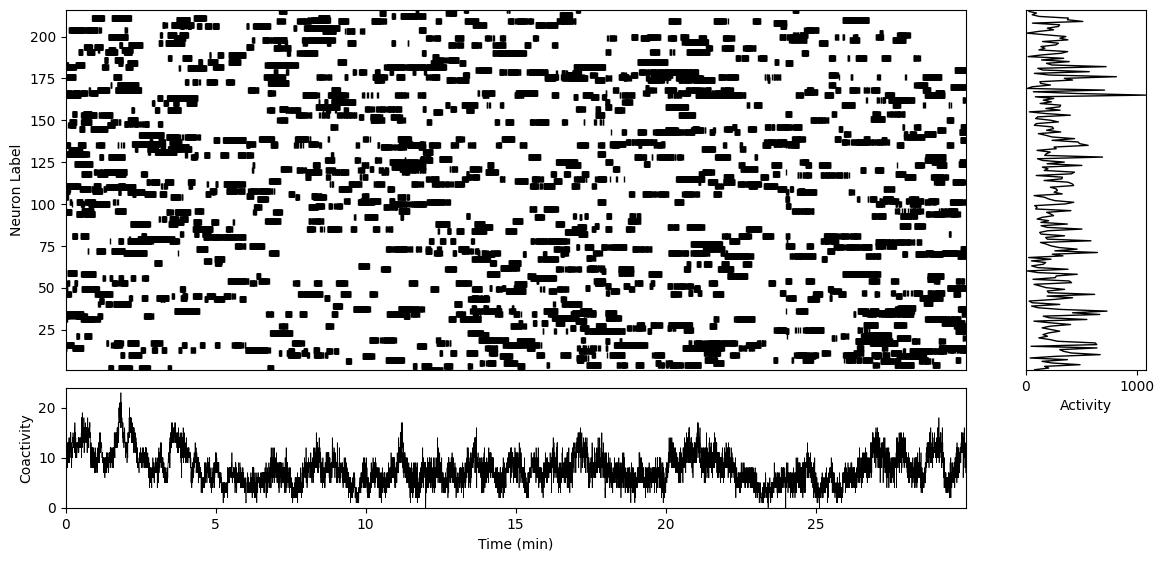

In [4]:
# Frame rate in frames per second, representing the video acquisition rate
fps = 4

# Generate and display the raster plot using the neurolab module
nl.plot_raster(raster, fps)

## Analysis of Node Strength Distributions

In this section, we analyze how variations in the parameters of the UMAP algorithm, specifically the number of neighbors (`n_neighbors`) and the metric used (`metric`), influence the structural properties of the graphs generated from the neuronal data. The strength of a node in a graph, defined as the sum of the weights of its connecting edges, can provide insights into the neuron's connectivity and influence within the network.

We apply UMAP to the preprocessed raster matrix using different combinations of metrics and `n_neighbors` values to generate graphs. For each graph, we compute the node strengths and analyze their distributions to understand the impact of these parameters on the network's topology.

### Generating and Analyzing Graphs

The following code section applies UMAP with varying parameters, constructs graphs from the resulting embeddings, and calculates node strengths. It then plots the distribution of these strengths across different settings to visually assess how parameter choices affect the graph characteristics.

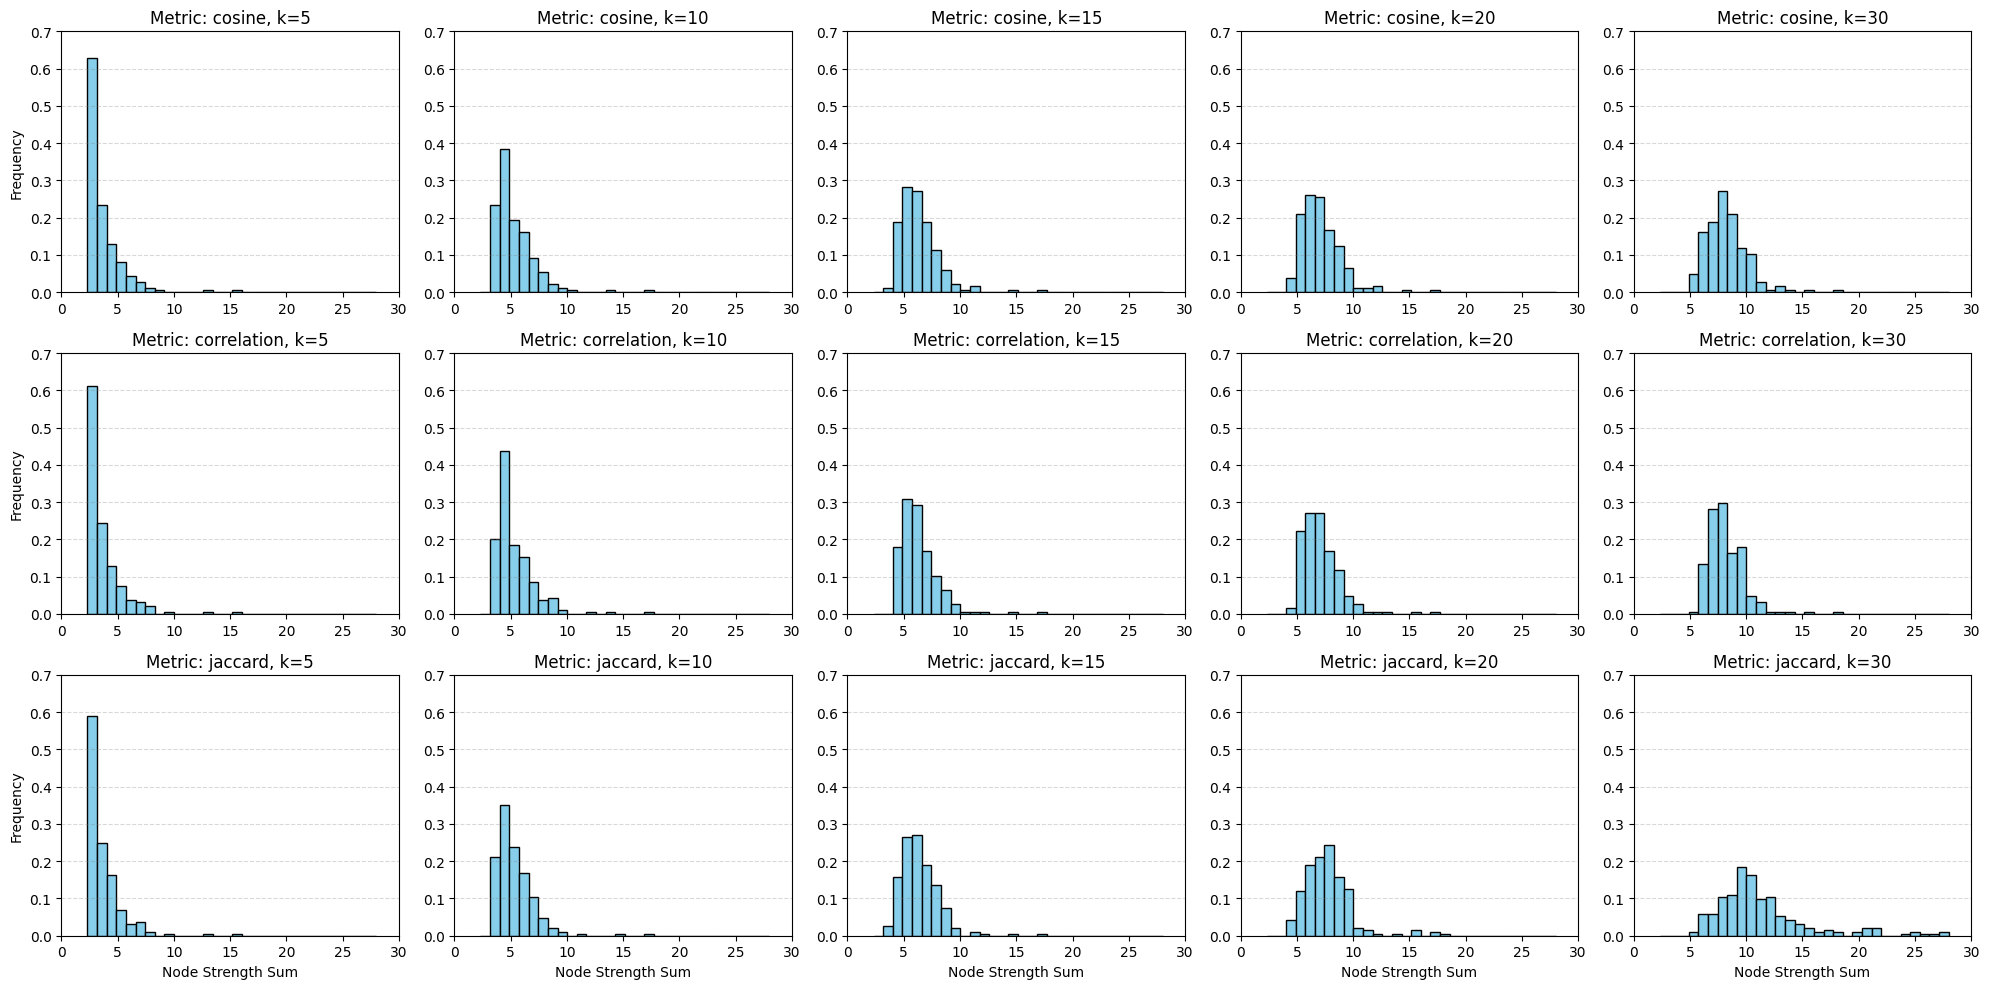

In [6]:
metrics = ['cosine', 'correlation', 'jaccard']  # Metrics to be used for UMAP distance calculations.
n_neighbors_values = [5, 10, 15, 20, 30]  # Different k-values for UMAP to explore effect of neighborhood size.

strength_distributions = {}  # Dictionary to store the distributions of node strengths for each setting.

for metric in metrics:
    strength_distributions[metric] = {}
    for n_neighbors in n_neighbors_values:
        # Configure and apply UMAP to transform the raster data into a two-dimensional embedding using specified metric and neighbors.
        mapper = umap.UMAP(n_neighbors=n_neighbors, n_components=2, random_state=42, metric=metric).fit(raster)
        # Extract the adjacency matrix from the UMAP output.
        adjacency_matrix = nl.get_adjacency_matrix(mapper)
        # Convert the adjacency matrix into a graph.
        G = nx.from_numpy_array(adjacency_matrix)
        
        # Calculate and store the sums of node strengths for the graph.
        node_strengths = nl.calculate_node_strengths(G)
        strength_distributions[metric][n_neighbors] = list(node_strengths.values())

# Setup for plotting the results
fig, axes = plt.subplots(nrows=len(metrics), ncols=len(n_neighbors_values), figsize=(20, 10))

# Initialize variables to determine global plot limits
global_min = np.inf
global_max = -np.inf
global_max_height = 0

# Calculate global minimum, maximum, and maximum histogram height for consistent plot scaling
for metric in metrics:
    for n_neighbors in n_neighbors_values:
        data = strength_distributions[metric][n_neighbors]
        global_min = min(global_min, min(data))
        global_max = max(global_max, max(data))
        counts, _ = np.histogram(data, bins=20)
        normalized_max_height = max(counts) / raster.shape[0]  # Normalize by total number of cells for scaling
        global_max_height = max(global_max_height, normalized_max_height)

# Set consistent x and y limits for all subplots based on calculated global limits
global_x_limits = (global_min, global_max)
global_y_limits = (0, global_max_height * 1.5)

fixed_bins = 30  # Set a fixed number of bins for histogram plots

# Plotting loop for each combination of metrics and n_neighbors
for i, metric in enumerate(metrics):
    for j, n_neighbors in enumerate(n_neighbors_values):
        ax = axes[i][j]
        data = strength_distributions[metric][n_neighbors]
        bins = np.histogram_bin_edges(data, bins=fixed_bins, range=global_x_limits)
        counts, _, _ = ax.hist(data, bins=bins, color='skyblue', edgecolor='black', density=True)
        counts /= raster.shape[0]  # Further normalize by total number of cells for visual clarity
        ax.set_xlim((0, 30))
        ax.set_ylim((0, 0.7))
        ax.set_title(f'Metric: {metric}, k={n_neighbors}')
        if j == 0:
            ax.set_ylabel('Frequency')
        if i == len(metrics) - 1:
            ax.set_xlabel('Node Strength Sum')
        ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.3)

plt.tight_layout()
#plt.savefig("node_strength_distributions.svg", format='svg', dpi=300, transparent=True)
plt.show()

## Comparative Analysis of Modularity and Number of Clusters

This section presents an analysis of how different similarity measures and neighbor settings in the UMAP algorithm affect the modularity and clustering in the generated graphs. Modularity is a measure that evaluates the strength of division of a network into modules (clusters). A higher modularity value indicates a strong division, implying that the nodes within the same module are densely connected.

We perform a series of simulations to observe the variations in modularity and the number of clusters formed across different configurations. This helps us understand the influence of the UMAP parameters on the graph structure and the community detection capabilities of the Louvain algorithm.

### Simulation Setup and Analysis

We run a thousand simulations for each combination of similarity measure and number of neighbors to obtain a robust statistical understanding of how these parameters influence the network structure.

Total Simulations: 100%|██████████| 10/10 [05:05<00:00, 30.55s/it]


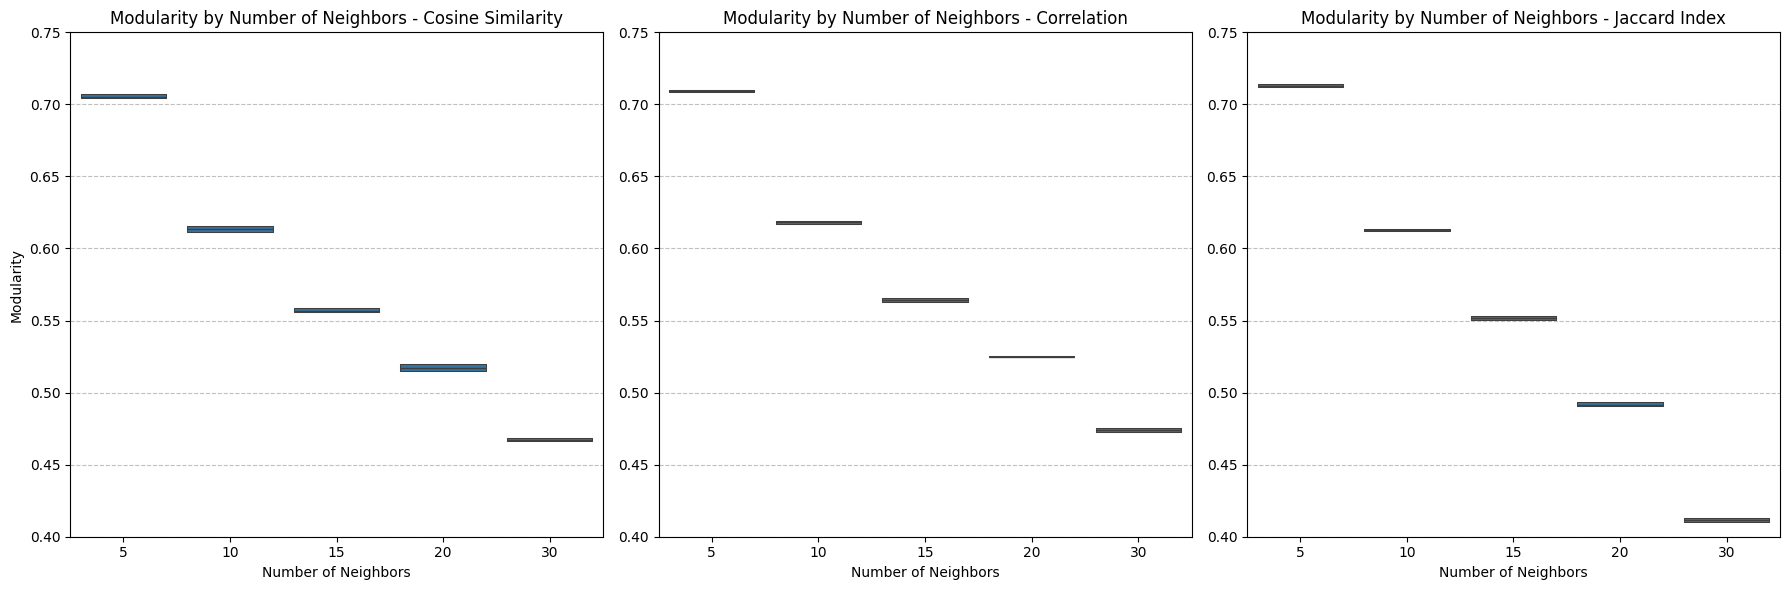

In [7]:
# Define similarity measures and neighbor values to test
metrics = ['cosine', 'correlation', 'jaccard']
n_neighbors_values = [5, 10, 15, 20, 30]
num_simulations = 10 # You can change the value for testing purposes

# Dictionary to store the results for each metric and neighbor setting
results = {metric: {n_neighbors: {'modularities': [], 'num_clusters': []}
                    for n_neighbors in n_neighbors_values}
           for metric in metrics}

# Run simulations to collect data
for simulation in tqdm(range(num_simulations), desc='Total Simulations'):
    for metric in metrics:
        for n_neighbors in n_neighbors_values:
            # Generate a graph using UMAP with the specified metric and neighbor settings
            mapper = umap.UMAP(n_neighbors=n_neighbors, n_components=2, random_state=42, metric=metric).fit(raster)
            adjacency_matrix = nl.get_adjacency_matrix(mapper)
            G = nx.from_numpy_array(adjacency_matrix)

            # Compute the best partition using the Louvain algorithm and calculate modularity
            partition = community_louvain.best_partition(G)
            modularity = community_louvain.modularity(partition, G)
            num_clusters = len(set(partition.values()))
            
            # Store the results of modularity and number of clusters
            results[metric][n_neighbors]['modularities'].append(modularity)
            results[metric][n_neighbors]['num_clusters'].append(num_clusters)

# Prepare data for visualization
modularity_data = []
clusters_data = []
for metric in metrics:
    for n_neighbors in n_neighbors_values:
        data = results[metric][n_neighbors]
        for modularity in data['modularities']:
            modularity_data.append({
                'Similarity Measure': metric,
                'Neighbors': n_neighbors,
                'Modularity': modularity
            })
        for num_clusters in data['num_clusters']:
            clusters_data.append({
                'Similarity Measure': metric,
                'Neighbors': n_neighbors,
                'Clusters': num_clusters
            })

# Convert data lists to DataFrame for plotting
df_modularity = pd.DataFrame(modularity_data)
df_clusters = pd.DataFrame(clusters_data)

# Create the figure with three subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Titles based on similarity measures for each subplot
titles = {
    'cosine': 'Cosine Similarity',
    'correlation': 'Correlation',
    'jaccard': 'Jaccard Index'
}

# Plotting loop for each similarity measure
for i, metric in enumerate(['cosine', 'correlation', 'jaccard']):
    ax = axes[i]
    # Filter data for the current similarity measure
    subset = df_modularity[df_modularity['Similarity Measure'] == metric]
    sns.boxenplot(x='Neighbors', y='Modularity', data=subset, ax=ax, k_depth='tukey', showfliers=False)
    ax.set_title(f'Modularity by Number of Neighbors - {titles[metric]}')
    ax.set_xlabel('Number of Neighbors')
    ax.set_ylabel('Modularity' if i == 0 else '')  # Y-label only on the first subplot for clarity
    ax.set_ylim(0.4, 0.75)  # Consistent y-limits for each subplot

    # Add horizontal grids for better readability
    ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.5)

# Adjust subplot spacing to prevent label overlap
plt.tight_layout()
#plt.savefig("boxplots.svg", format='svg', dpi=300, transparent=True)
plt.show()

## Heatmap Visualization of Cluster Counts

In this section, we explore the distribution of cluster counts across different UMAP parameter settings. By visualizing the data as heatmaps, we can better understand the influence of the number of neighbors (`n_neighbors`) and the similarity measure on the clustering behavior observed in the graphs. Heatmaps provide a clear visual representation of how these parameters affect the prevalence and variability of cluster counts.

### Generating Heatmaps

Each heatmap corresponds to one of the three similarity measures tested: cosine, correlation, and Jaccard. These visualizations display the percentage of simulations that resulted in a given number of clusters, highlighting the stability and commonality of clustering configurations across different UMAP settings.

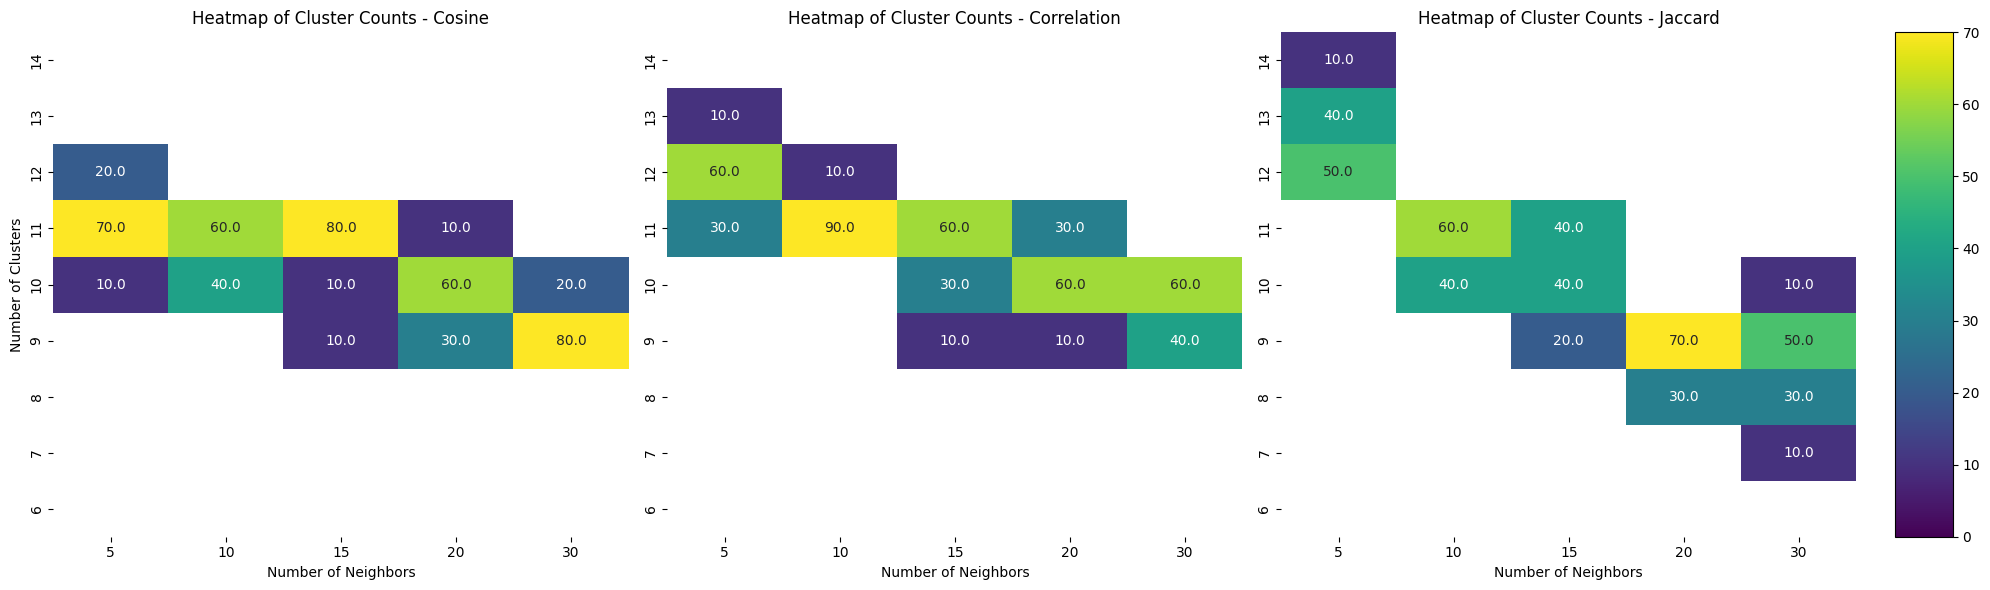

In [8]:
# Set up the figure with three subplots for each metric plus an additional space for the color bar
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 6), gridspec_kw={'width_ratios': [1, 1, 1, 0.1]})

# Define the metrics to be plotted
metrics = ['cosine', 'correlation', 'jaccard']

for i, metric in enumerate(metrics):
    ax = axes[i]
    
    # Filter data for the current metric
    df_filtered = df_clusters[df_clusters['Similarity Measure'] == metric]
    
    # Create a pivot table for cluster counts based on the current metric
    pivot_table = df_filtered.pivot_table(index='Clusters', columns='Neighbors', aggfunc='size', fill_value=0)
    
    # Filter the cluster range to include only clusters from 6 to 14
    pivot_table = pivot_table.reindex(range(6, 15)).fillna(0)
    
    # Convert counts to percentages of the total counts per column
    pivot_percentage = pivot_table.div(pivot_table.sum()).multiply(100)
    
    # Create a heatmap for the cluster counts without color bars in each map
    sns.heatmap(pivot_percentage, annot=True, fmt=".1f", cmap='viridis', ax=ax, cbar=False,
                vmin=0, vmax=70,  # Set consistent color limits
                mask=pivot_percentage == 0)  # Mask zero values for cleaner visualization
    
    # Configure the plot
    ax.set_title(f'Heatmap of Cluster Counts - {metric.capitalize()}')
    ax.set_xlabel('Number of Neighbors')
    ax.set_ylabel('Number of Clusters' if i == 0 else '')  # Only set y-label on the first subplot for clarity
    ax.set_yticks(np.arange(0.5, len(pivot_table.index) + 0.5))
    ax.set_yticklabels(pivot_table.index)
    ax.invert_yaxis()  # Invert the y-axis to have smaller values at the bottom

# Place the color bar in the last subplot space
cbar_ax = axes[-1]
fig.colorbar(axes[0].collections[0], cax=cbar_ax, orientation='vertical')

# Adjust the layout to ensure everything fits well
plt.tight_layout()
#plt.savefig("heatmap_cluster_counts.svg", format='svg', dpi=300, transparent=True)
plt.show()

## Final Graph Analysis Using UMAP and Louvain Community Detection

In this final section of our analysis, we focus on applying the Uniform Manifold Approximation and Projection (UMAP) algorithm with optimal parameters selected based on our previous analyses. This involves using a specific number of neighbors and a similarity measure that best suits our data characteristics. We then use the Louvain algorithm for community detection to identify and analyze clusters or neuronal ensembles within the graph. This approach helps in understanding the organizational structure of the neuronal network and the interaction patterns among neurons.

### Graph Construction and Community Detection

The following steps illustrate how to construct the graph using UMAP and detect communities within it using the Louvain algorithm. This process is crucial for our understanding of the functional connectivity and modular structure within the neuronal data.

In [12]:
# Set the optimal parameters for UMAP based on prior exploratory analysis
mapper = umap.UMAP(n_neighbors=5,  # Optimal number of neighbors
                   n_components=2,  # Number of dimensions to project down to
                   random_state=42,  # Seed for reproducibility
                   metric='jaccard').fit(raster)  # Using Jaccard similarity for its relevance to binary data

# Obtain the adjacency matrix from the UMAP output
adjacency_matrix  = nl.get_adjacency_matrix(mapper)

# Convert the adjacency matrix into a graph structure
graph = nx.from_numpy_array(adjacency_matrix )

# Apply the Louvain algorithm to detect communities within the graph
partition = community_louvain.best_partition(graph)

# The partition variable now contains the node-community assignments, indicating which node belongs to which community

## Visualization of Neuronal Ensembles

### Clustered Raster Plot

After applying the UMAP and Louvain community detection algorithm, the next step is to visualize the detected neuronal ensembles to assess their activity patterns over time. This visualization is crucial as it provides insights into how neurons are grouped into functional clusters and how these clusters behave dynamically throughout the experiment.

#### Raster Plot of Neuronal Clusters

The clustered raster plot illustrates the temporal activity of each neuron, now organized by the communities detected through the Louvain algorithm. This organization allows us to observe the synchronicity and interaction within and across different neuronal ensembles. Each row in the plot represents a neuron, and the neurons are grouped and color-coded according to their community, highlighting the temporal dynamics of their activity.

This visualization is not only essential for confirming the relevance and accuracy of the community detection but also serves as a powerful tool for identifying patterns of co-activity that might be linked to specific neural functions or behaviors.

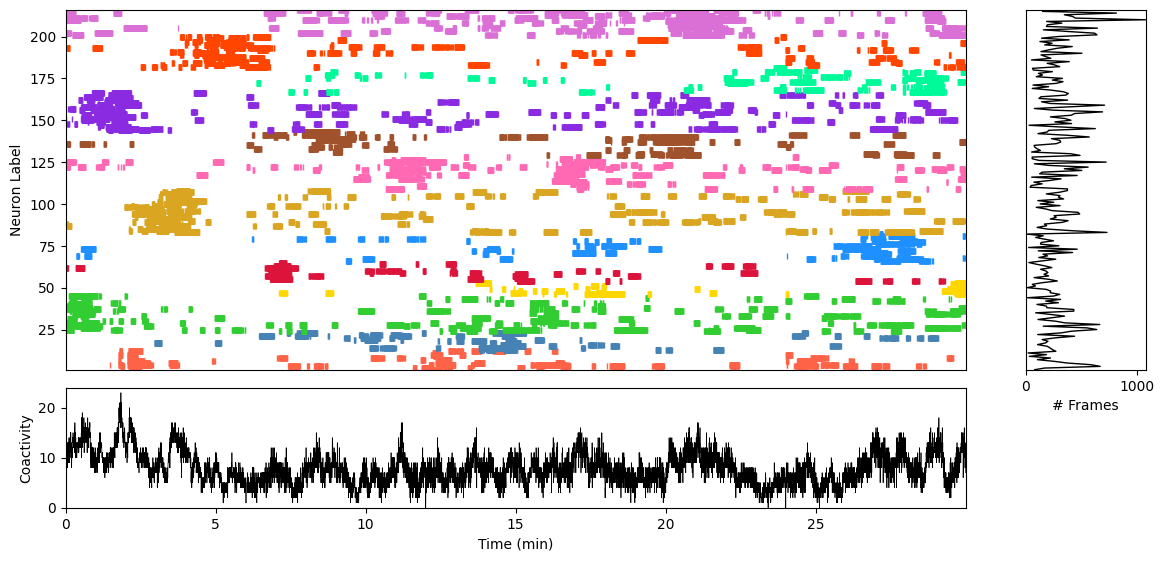

In [13]:
# Plot the clustered raster plot using neurolab's plot_cluster_raster function
# 'raster' is the binary matrix of neuronal activity, 'fps' is the frame rate, and 'partition' contains community assignments
nl.plot_cluster_raster(raster, fps, partition)

#plt.savefig("cluster_raster.svg", format='svg', dpi=300, transparent=True)

## Visualization of the Adjacency Matrix

### Adjacency Matrix of the Graph

Following the formation of the graph using UMAP and the detection of communities with the Louvain algorithm, it is insightful to examine the adjacency matrix. The adjacency matrix provides a visual representation of the connections between the neurons in the graph. Each row and column represents a neuron, and the color intensity of each cell in the matrix indicates the strength or weight of the connection between corresponding neurons.

#### Displaying the Adjacency Matrix

Visualizing the adjacency matrix helps in understanding the overall connectivity pattern within the neuronal network. It allows us to see which neurons are more interconnected and which are less so, reflecting the underlying structure of the neuronal ensembles. This can provide insights into the co-activity and synchronization patterns among different groups of neurons.

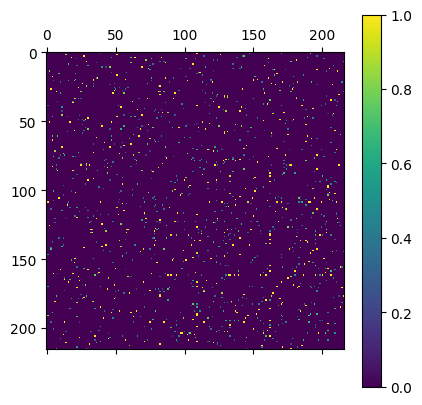

In [14]:
# Display the adjacency matrix using matplotlib
plt.matshow(adjacency_matrix , cmap='viridis')  # Apply the 'viridis' colormap for better visual distinction
plt.colorbar()  # Add a color bar to indicate the scale of connectivity weights
#plt.savefig('../figures/adj_matrix.svg', format='svg', dpi=300, transparent=True)  # Uncomment to save the figure
plt.show()  # Display the plot

## Reorganization of Neuronal Ensemble Indices

### Customizing Neuronal Ensemble Order

In this section, we adjust the order of the neuronal ensembles identified through the community detection process to enhance the visualization and interpretation of the results. By reorganizing the neuronal ensemble indices, users can arrange the ensembles in an order that may be more meaningful or intuitive for their specific analysis. This does not affect the underlying results but can make the patterns within the data easier to understand and present.

#### Remapping Neuronal Ensemble Indices

It is essential for users to review the number of neuronal ensembles identified in their analysis and adjust the mapping dictionary accordingly. This dictionary maps current neuronal ensemble indices to new ones, allowing users to customize how the ensembles are displayed in the raster plot. Proper configuration of this mapping ensures that the visualization aligns with the user's preferences or the specific requirements of the analysis.

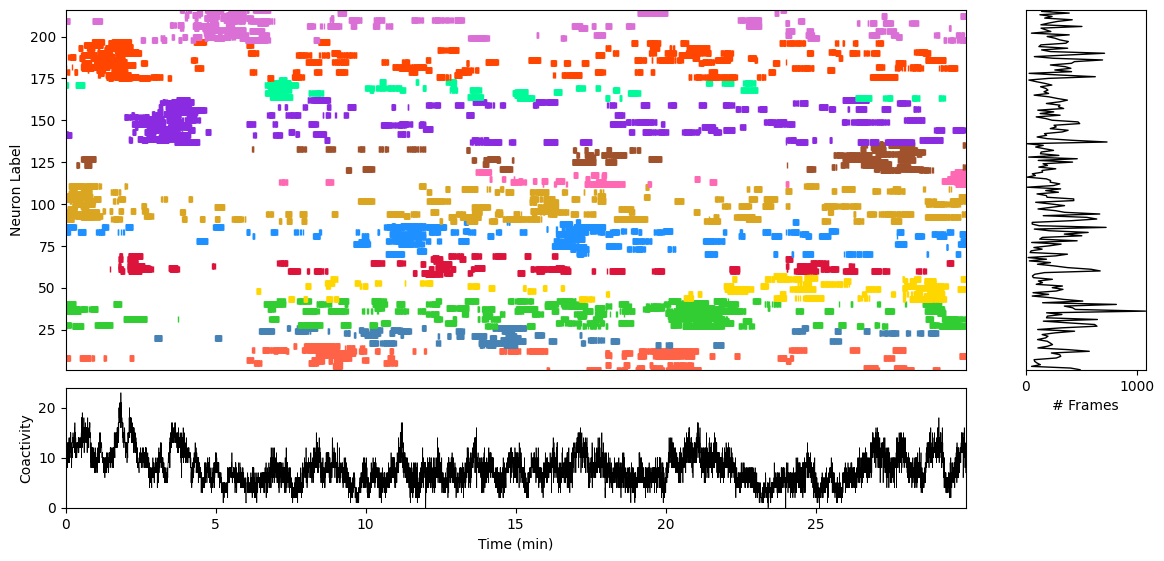

In [15]:
# Define a mapping from current cluster indices to new indices for better visualization
new_mapping = {
    0: 4, 1: 1, 2: 6, 3: 7, 4: 10, 5: 8,
    6: 9, 7: 5, 8: 0, 9: 11, 10: 3, 11: 12, 12: 2
}

# Remap the partitions to new cluster indices using a helper function from neurolab
new_partition = nl.remap_partitions(partition, new_mapping)

# Plot the clustered raster plot using the remapped cluster indices
nl.plot_cluster_raster(raster, fps, new_partition)

## Circular Layout Visualization of the Graph

### Graph Representation by Neuronal Ensembles

This section of the analysis presents a circular layout visualization of the graph, where each node represents a neuron, and each node's color corresponds to the neuronal ensemble it belongs to as identified by the community detection algorithm. This visualization method helps in illustrating the connectivity and interaction patterns among different neuronal ensembles within the network.

#### Node and Edge Visualization

In the circular layout, nodes are arranged in a circle, sorted by their community assignments. The size of each node is proportional to its node strength, reflecting the importance or connectivity level of the neuron in the network. Edges between nodes are colored to indicate the interaction between different ensembles, with the color representing a blend of the connected nodes' colors. This method of coloring helps in visualizing the strength and nature of the inter-ensemble connections.

This graph provides a comprehensive view of how neuronal ensembles are interconnected and how densely each ensemble is linked within the network, offering insights into the structural organization of the neuronal circuits.

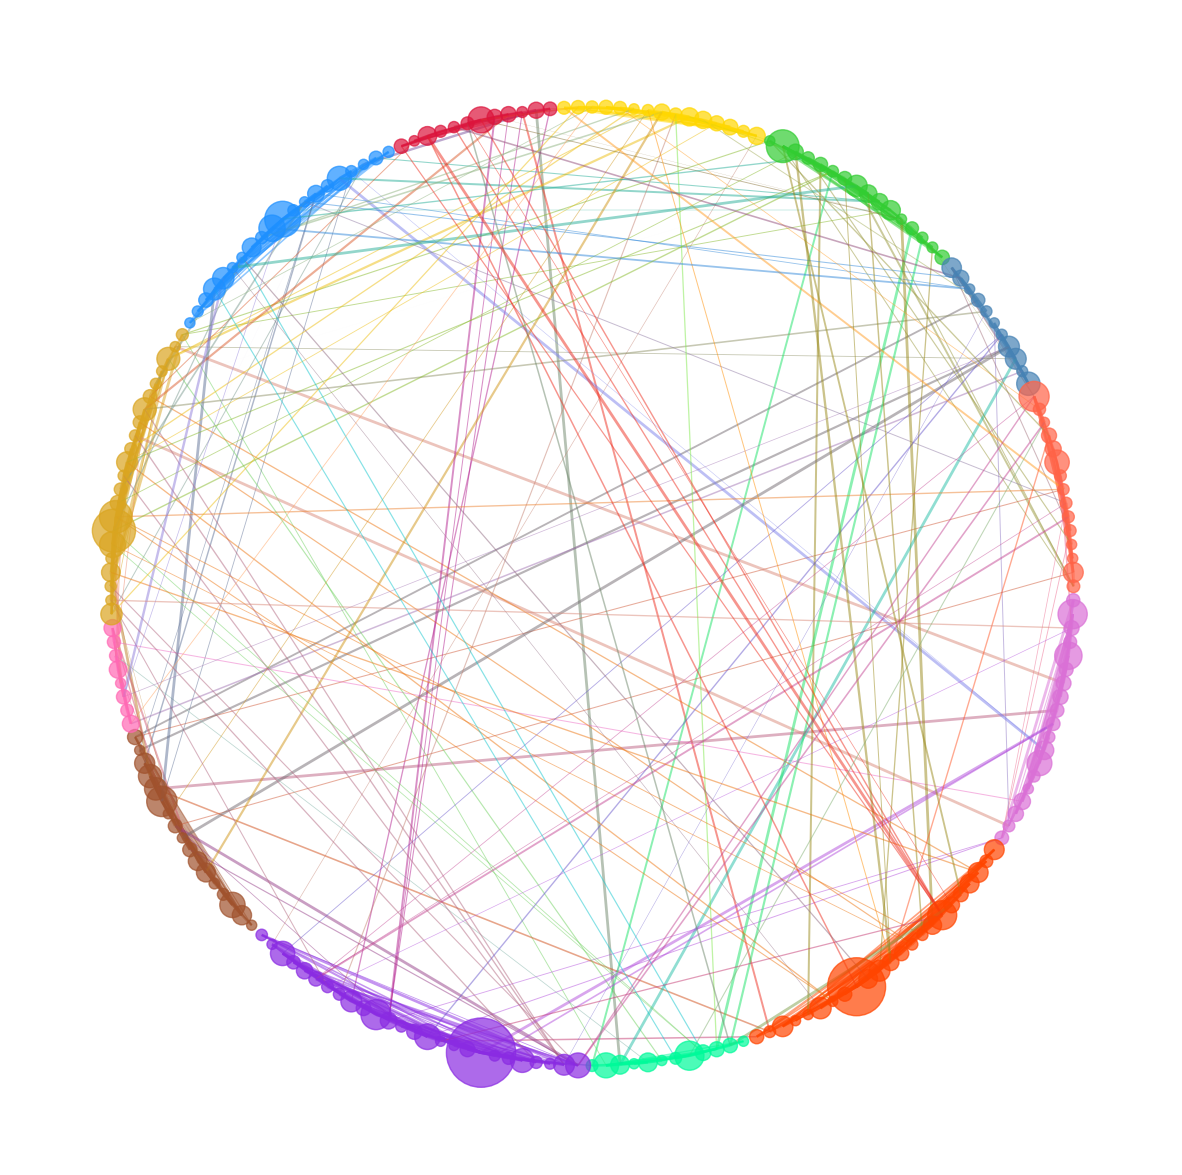

In [16]:
# Calculate node strengths from the graph
node_strengths = nl.calculate_node_strengths(graph)  # Assumes calculate_node_strengths is defined earlier

# Calculate node sizes based on their strength
node_sizes = [node_strengths[node] ** 2 * 10 for node in graph.nodes()]

# Sort nodes by cluster and calculate positions in a circular layout
nodes_sorted_by_cluster = sorted(graph.nodes(), key=lambda x: new_partition[x])
angle_step = 2 * np.pi / len(graph.nodes())
pos = {node: (np.cos(angle_step * i), np.sin(angle_step * i)) for i, node in enumerate(nodes_sorted_by_cluster)}

# Ensure that colors are in the correct order
node_colors = [nl.colors_hex[new_partition[node] % len(nl.colors_hex)] for node in graph.nodes()]

# Convert hex colors to RGB for blending
node_colors_rgb = [mcolors.hex2color(color) for color in node_colors]

# Draw the graph
plt.figure(figsize=(15, 15))

# Draw each edge with a color blended from the nodes it connects
for (u, v) in graph.edges():
    edge_color = np.mean([node_colors_rgb[list(graph.nodes()).index(u)], node_colors_rgb[list(graph.nodes()).index(v)]], axis=0)
    edge_weight = graph[u][v]['weight']
    nx.draw_networkx_edges(graph, pos, edgelist=[(u, v)], width=edge_weight * 2, alpha=0.5, edge_color=[edge_color])

# Draw the nodes
nx.draw_networkx_nodes(graph, pos, node_size=node_sizes, node_color=node_colors, alpha=0.7)

plt.axis('off')
#plt.savefig("circular_layout.svg", format='svg', dpi=300, transparent=True)
plt.show()

## Spring Layout Visualization of the Graph

### Enhanced Graph Representation

This section builds upon the previous visualization by implementing a spring layout, which positions nodes in a way that reflects their connections' strengths and minimizes overlap. This layout can often reveal additional structure and patterns in the data that are not as evident in a circular layout.

#### Node Positioning and Edge Visualization

Using an initial circular arrangement as a starting point, the `spring_layout` algorithm adjusts the positions of the nodes based on the strength of their connections, creating a more dynamic and informative visual representation. This layout is particularly useful for emphasizing the interactions between densely connected nodes and for providing a clearer understanding of the network's overall structure.

Here, nodes are still color-coded by their community assignments, and their size is indicative of their node strength. Edges are colored to blend the connected nodes' colors, providing a visual representation of the connectivity strength.

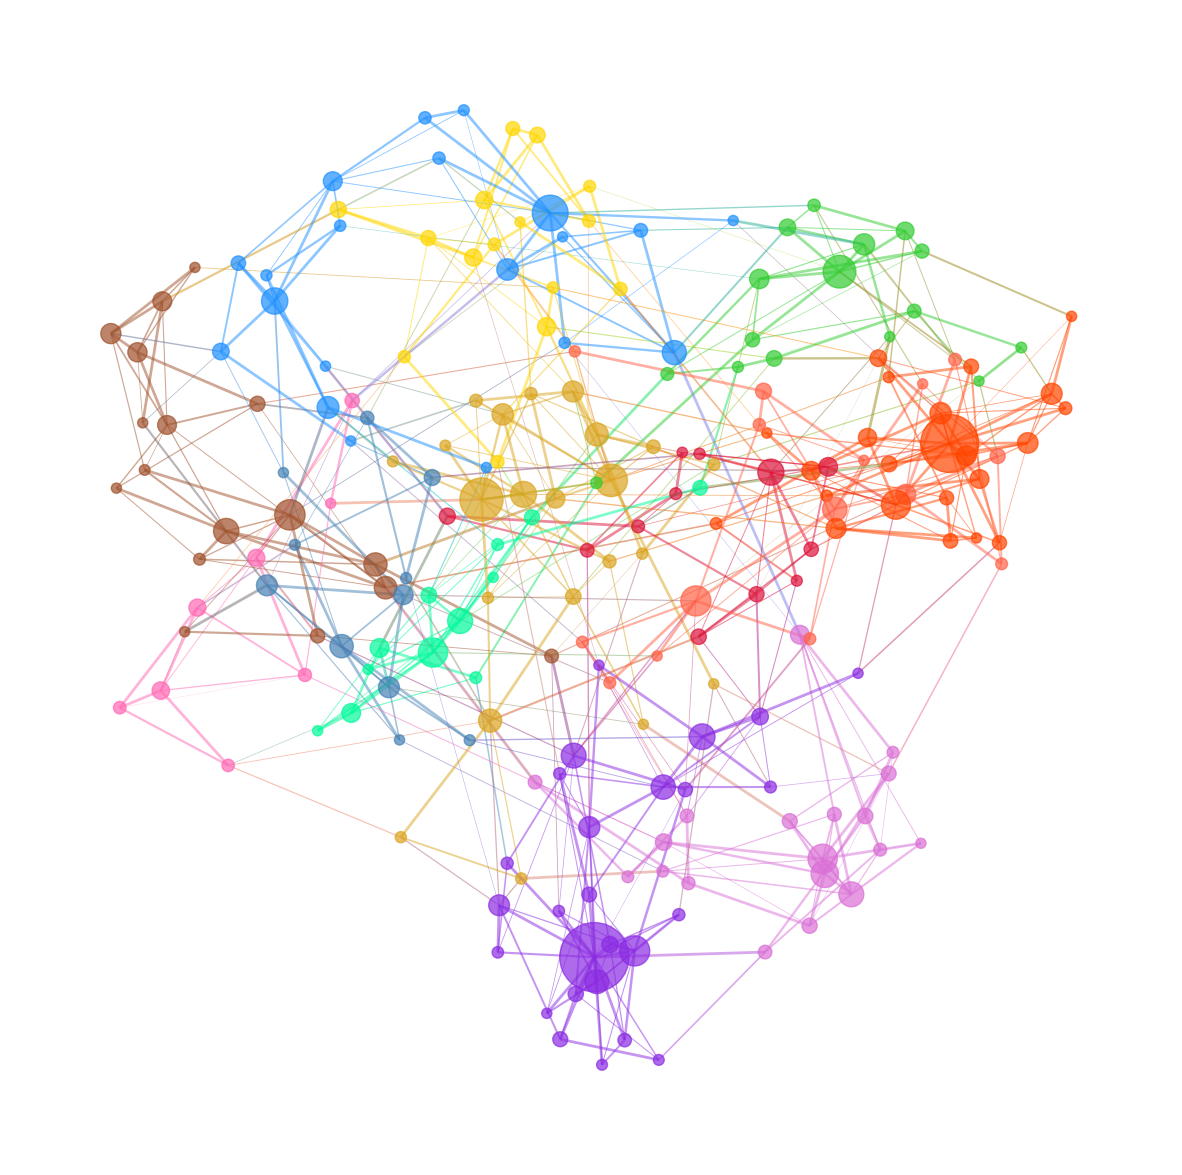

In [17]:
# Calculate node strengths from the graph
node_strengths = nl.calculate_node_strengths(graph)  # Assumes calculate_node_strengths is defined earlier

# Initial circular positions as a starting point for the spring layout
angle_step = 2 * np.pi / len(graph.nodes())
initial_pos = {node: (np.cos(angle_step * i), np.sin(angle_step * i))
               for i, node in enumerate(sorted(graph.nodes(), key=lambda x: new_partition[x]))}

# Apply the spring layout to optimize node positions based on their connections
pos = nx.spring_layout(graph, pos=initial_pos, weight='weight', iterations=100, seed=42)

# Node colors and sizes
node_sizes = [node_strengths[node] ** 2 * 10 for node in graph.nodes()]
node_colors = [nl.colors_hex[new_partition[node] % len(nl.colors_hex)] for node in graph.nodes()]

# Convert hex colors to RGB and calculate edge colors
node_colors_rgb = [mcolors.hex2color(color) for color in node_colors]
edge_colors = [np.mean([node_colors_rgb[list(graph.nodes()).index(u)], node_colors_rgb[list(graph.nodes()).index(v)]], axis=0)
               for u, v in graph.edges()]
edge_widths = [G[u][v]['weight'] * 2 for u, v in graph.edges()]

# Draw the graph using the spring layout
plt.figure(figsize=(15, 15))
nx.draw_networkx_edges(graph, pos, width=edge_widths, alpha=0.5, edge_color=edge_colors)
nx.draw_networkx_nodes(graph, pos, node_size=node_sizes, node_color=node_colors, alpha=0.7)
plt.axis('off')
#plt.savefig("graph_spring_layout.svg", format='svg', dpi=300, transparent=True)
plt.show()

## Conclusion

### Summary of Findings

Throughout this Jupyter notebook, we have utilized advanced graph theory techniques and UMAP (Uniform Manifold Approximation and Projection) to analyze complex neuronal data. Our focus was on identifying neuronal ensembles, which are crucial for understanding the brain's functional architecture and its involvement in various cognitive functions.

We started with the preprocessing of calcium imaging data, transforming it into a binary raster matrix format. This allowed us to effectively apply community detection algorithms and UMAP to explore the structural and functional connectivity of neuronal circuits.

### Key Insights

1. **Neuronal Ensembles Identification**: Using the Louvain algorithm for community detection, we successfully identified distinct neuronal ensembles. These ensembles represent groups of neurons with correlated activity, suggesting their collective involvement in specific brain functions.
2. **Graph-Based Visualization**: The visualizations provided (including circular and spring layout graphs) not only demonstrated the connectivity within and between these ensembles but also highlighted the complex interaction patterns that govern neuronal communication.
3. **Enhanced Understanding of Neuronal Architecture**: The analysis helped clarify how neurons organize into functional groups, offering insights into the brain's modular structure which is pivotal for both healthy brain function and its dysfunctions.

### Implications for Further Research

The methodologies and findings presented here pave the way for further studies into neuronal connectivity. Researchers are encouraged to apply these techniques to different datasets or under varying conditions to explore how neuronal networks adapt and change. Additionally, the open-source nature of the code and methods encourages further customization and development, potentially leading to new discoveries in neuroscience.

### Invitation to Collaborate

We invite fellow researchers and students to engage with our work by exploring the accompanying GitHub repository, which includes all relevant codes and examples. We look forward to seeing how others might extend and apply this work to new challenges in understanding the brain.

Thank you for your interest and engagement with this chapter. We hope it has provided you with valuable insights and tools for your own research into the fascinating field of computational neuroscience.

## Saving and Loading the Notebook Environment

### Ensuring Reproducibility

In computational research, reproducibility is crucial. To facilitate this, it is important to be able to save the entire state of your notebook environment, including all variables and imports. This allows you or others to reload the environment later and resume work with the same data and settings, ensuring consistent results.

### How to Save Your Environment

The Python `dill` package can serialize and deserialize Python objects, effectively saving the current state of your Jupyter notebook environment. This includes all variables, imports, and even open file objects, offering a comprehensive snapshot of your session at any point in time.

#### Saving Your Session

To save the current state of your notebook environment, use the following code:

In [ ]:
import dill

# Save the entire notebook environment to a file
with open('environment.pkl', 'wb') as file:
    dill.dump_session(file)

This will create a file named `environment.pkl` which stores the complete environment.

### How to Load Your Environment

Loading the saved environment is just as straightforward. When you or someone else needs to resume work, you can load the environment back into a Jupyter notebook, restoring all previously saved variables and imports.

#### Loading Your Session

To load an existing saved session, use the code below:

In [ ]:
import dill

# Load the entire notebook environment from the file
with open('environment.pkl', 'rb') as file:
    dill.load_session(file)

This will restore the notebook to the state it was in when the environment was last saved, allowing for a seamless continuation of your work.

### Conclusion

Using `dill` to save and load your notebook's environment is an effective way to ensure the reproducibility of your computational analyses. This practice is highly recommended, especially in environments where consistent results are critical for the validity of your findings.